### Fantasy Premier Leage player price change predictor

Fantasy Premier League (FPL), is an online game where users have a certain budget (100) to get the best performing players.
The players get points by scoring goals, providing assists or keeping clean sheets if they're a defender or goalkeeper (+ others).
The highest performing players usually have a bigger price tag at the beginning of the season. Depending on how a player performs and how many users are transferring him in or out of their squad, the player might get a price rise or price drop by 0.1. This can happen every gameweek.

In this project I'm trying to create a model that accurately predicts if a player will have a price drop or price rise (or remain unchanged).
Since there are 3 possible outcomes, this is a non-binary classification model.

In [105]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from pycaret.classification import *
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.regularizers import l1_l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
import joblib
pd.options.mode.chained_assignment = None

### First we get the data from the API, and then create the dataframe

We get various features like total points, transfer balance and more, and also create some other features like delta which shows the percentage of change in selection.
We also create the validation column price_change

In [2]:
%%time

data_list = []
columns = ['total_points', 'value', 'selected', 'goals_scored', 'assists', 'clean_sheets', 'transfers_in', 'transfers_out', 'transfers_balance', 'delta', 'player_id', 'round', 'price_change']

for i in range(1,730): # We're getting data from 730 players
    if(i == 612):
        continue # This page was empty
    url = f'https://fantasy.premierleague.com/api/element-summary/{i}/'
    r = requests.get(url)
    data = r.json()
    for gameweek in data['history']:
        row = {col: gameweek[col] if col in gameweek else None for col in columns}
        row['player_id'] = i
        row['price_change'] = 0 # We'll change this later
        if(gameweek['selected'] != 0):
            row['delta'] = round(gameweek['transfers_balance']/gameweek['selected'] *100, 1)
        else:
            row['delta'] = 0
        data_list.append(row)

df = pd.DataFrame(data_list)

CPU times: total: 5min 6s
Wall time: 7min 21s


In [5]:
# Set price change to 1 if there was a price rise, and set it to 2 for price drop
for i in range(1, df.shape[0]):
    currentValue = df.loc[i, 'value']
    previousValue = df.loc[i-1, 'value']
    currentPlayer = df.loc[i, 'player_id']
    previousPlayer = df.loc[i-1, 'player_id']
    if(currentPlayer == previousPlayer and currentValue != previousValue):
        if(currentValue > previousValue):
            df.at[i, 'price_change'] = 1
        else:
            df.at[i, 'price_change'] = 2

In [6]:
# Add another feature, previous points
df['previous_points'] = df['total_points'].shift(1)
df['previous_points'] = df['previous_points'].where(df['player_id'] == df['player_id'].shift(1))

In [7]:
df.describe()

,total_points,value,selected,goals_scored,assists,clean_sheets,transfers_in,transfers_out,transfers_balance,delta,player_id,round,price_change,previous_points
count,9973.000000,9973.000000,9.973000e+03,9973.000000,9973.000000,9973.000000,9.973000e+03,9.973000e+03,9.973000e+03,9973.000000,9973.000000,9973.000000,9973.000000,9245.000000
mean,1.129349,48.879073,2.068557e+05,0.042114,0.038705,0.068685,1.665434e+04,1.653718e+04,1.171556e+02,-2.190214,357.074301,7.647448,0.175273,1.130665
std,2.323495,10.240774,6.502923e+05,0.221741,0.213151,0.252931,6.822419e+04,6.504001e+04,8.519148e+04,15.421541,206.424457,3.970060,0.544971,2.326269
min,-4.000000,38.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-2.176609e+06,-233.700000,1.000000,1.000000,0.000000,-4.000000
25%,0.000000,44.000000,3.632000e+03,0.000000,0.000000,0.000000,2.000000e+01,1.610000e+02,-1.342000e+03,-7.200000,179.000000,4.000000,0.000000,0.000000
50%,0.000000,45.000000,1.492800e+04,0.000000,0.000000,0.000000,3.280000e+02,9.600000e+02,-1.180000e+02,-2.200000,357.000000,8.000000,0.000000,0.000000
75%,1.000000,50.000000,8.588200e+04,0.000000,0.000000,0.000000,3.276000e+03,6.306000e+03,2.100000e+01,0.400000,535.000000,11.000000,0.000000,1.000000
max,23.000000,141.000000,9.241818e+06,3.000000,4.000000,1.000000,1.372076e+06,2.197741e+06,1.337346e+06,94.900000,729.000000,14.000000,2.000000,23.000000


#### We need to remove rows where the players are removed from the game

In [8]:
df = df[df['transfers_in'] != 0]
df

,total_points,value,selected,goals_scored,assists,clean_sheets,transfers_in,transfers_out,transfers_balance,delta,player_id,round,price_change,previous_points
1,0,45,63768,0,0,0,4959,9703,-4744,-7.4,1,2,0,0.0
2,0,45,58109,0,0,0,2507,10189,-7682,-13.2,1,3,0,0.0
3,0,44,49814,0,0,0,2558,12254,-9696,-19.5,1,4,2,0.0
15,0,40,34540,0,0,0,1902,4552,-2650,-7.7,2,2,0,0.0
16,0,40,34131,0,0,0,1538,3822,-2284,-6.7,2,3,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9968,0,45,118,0,0,0,116,22,94,79.7,729,10,0,0.0
9969,0,45,218,0,0,0,109,38,71,32.6,729,11,0,0.0
9970,0,45,272,0,0,0,76,44,32,11.8,729,12,0,0.0
9971,0,45,329,0,0,0,97,63,34,10.3,729,13,0,0.0


In [9]:
# Save it so we don't have to make API calls everytime we start the project
df.to_csv('data.csv', index=False)

### Or we can import the data from csv we created before

In [ ]:
df = pd.read_csv('data.csv')
df

### Preprocessing the data

In [10]:
# First we simplify the dataframe
columns_to_keep = ['previous_points', 'selected', 'transfers_balance', 'delta', 'price_change', 'player_id']
df = df[columns_to_keep]
df.head()

,previous_points,selected,transfers_balance,delta,price_change,player_id
1,0.0,63768,-4744,-7.4,0,1
2,0.0,58109,-7682,-13.2,0,1
3,0.0,49814,-9696,-19.5,2,1
15,0.0,34540,-2650,-7.7,0,2
16,0.0,34131,-2284,-6.7,0,2


In [11]:
#check for null values
null_values = df.isnull().sum()
print(null_values)
df.shape[0]

previous_points      42
selected              0
transfers_balance     0
delta                 0
price_change          0
player_id             0
dtype: int64


7646

In [12]:
df = df.dropna()
df.shape[0]

7604

#### Dealing with some outliers

We will:
1. Remove rows where delta is positive and price falls
2. Remove rows where delta is negative and price rises
3. Remove rows where delta is extremely high or low and price stays unchanged

In [13]:
df = df[(df['delta'] >= 0) | (df['price_change'] != 1)] # if price went up and delta was negative we remove it
df = df[(df['delta'] < 0) | (df['price_change'] != 2)] # if price went down and delta was positive we remove it 
df.shape[0]

7533

In [15]:
# We will remove top 5% and bottom 5% of rows where the price stays unchanged based on delta
condition = (df['price_change'] == 0)
outliers = df[condition]['delta'].quantile([0.05, 0.95]) # -20.7 to 25.3
print(outliers)
# Remove outliers from the original DataFrame
df = df[~((df['price_change'] == 0) & ((df['delta'] < outliers[0.05]) | (df['delta'] > outliers[0.95])))]
df.shape[0]

0.05   -14.4
0.95    13.6
Name: delta, dtype: float64


6286

### Let's explore our data some more

In [16]:
noChange = df[df['price_change'] == 0]
priceUp = df[df['price_change'] == 1]
priceDown = df[df['price_change'] == 2]
print(noChange['delta'].mean())
print(priceUp['delta'].mean())
print(priceDown['delta'].mean())

-1.8743155149934811
22.493981481481484
-16.940513552068474


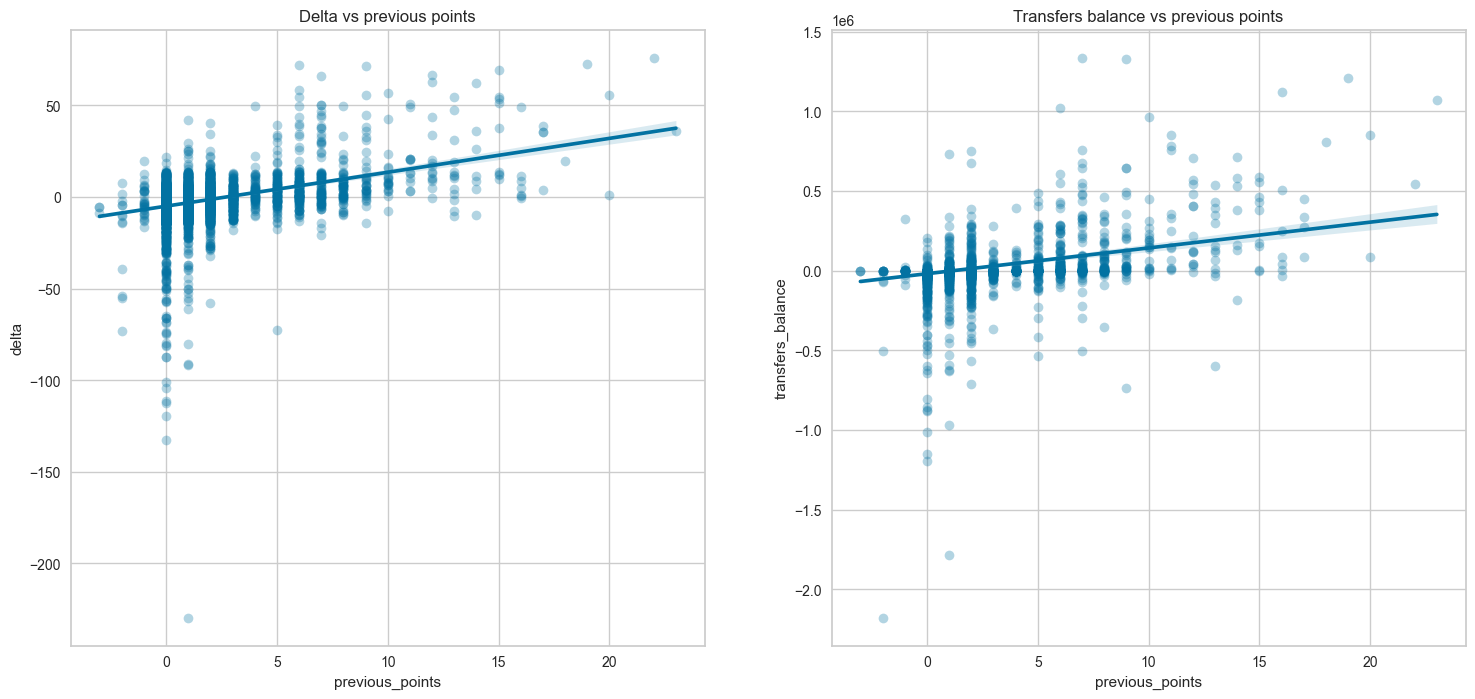

Correlation for delta: 0.38154642252043675
Correlation for transfers balance: 0.372332184877063


In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

#plt.title('Relationship between previous points and the transfer changes')
sns.regplot(x=df['previous_points'], y=df['delta'], scatter_kws={'alpha':0.3}, ax=ax1)
ax1.set_title("Delta vs previous points")

sns.regplot(x=df['previous_points'], y=df['transfers_balance'], scatter_kws={'alpha':0.3}, ax=ax2)
ax2.set_title("Transfers balance vs previous points")
plt.show()

transfersCC = np.corrcoef(df['previous_points'], df['transfers_balance'])[0, 1]
deltaCC = np.corrcoef(df['previous_points'], df['delta'])[0, 1]
print(f'Correlation for delta: {deltaCC}')
print(f'Correlation for transfers balance: {transfersCC}')

In [ ]:
sns.regplot(x=noChange['previous_points'], y=noChange['delta'], scatter_kws={'alpha':0.3})
correlation_coefficient = np.corrcoef(noChange['previous_points'], noChange['delta'])[0, 1]
print(f'Correlation: {correlation_coefficient}')

More to add here...

We need to standardize the data so that large values don't have more effect on the model than they should.
Also we split the data into training and test data

In [27]:
X = df.drop(['price_change', 'player_id'], axis=1)  # Exclude the target column
y = df['price_change']  # The target column

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X) # This standardizes the data

# Create a new DataFrame with standardized data
X = pd.DataFrame(X_standardized, columns=X.columns)
X

,previous_points,selected,transfers_balance,delta
0,-0.537371,-0.273379,-0.058900,-0.417877
1,-0.537371,-0.280670,-0.088164,-0.935441
2,-0.537371,-0.291357,-0.108224,-1.497622
3,-0.537371,-0.311037,-0.038043,-0.444648
4,-0.537371,-0.311564,-0.034398,-0.355413
...,...,...,...,...
6281,-0.537371,-0.354708,-0.011290,0.742179
6282,-0.537371,-0.354669,-0.011807,0.028298
6283,-0.537371,-0.355189,-0.011329,1.295436
6284,-0.537371,-0.355115,-0.011309,1.161583


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create a SVM model to predict the price change of a player

In [29]:
#class_weights = {0: 1, 1: 1, 2: 1}
svm_classifier = SVC(kernel='linear', C=1, decision_function_shape='ovr', probability=True) #class_weight=class_weights)  # 'ovr' for multiclass
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print other metrics like classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1086
           1       0.89      0.78      0.83        40
           2       0.97      0.24      0.39       132

    accuracy                           0.91      1258
   macro avg       0.92      0.67      0.72      1258
weighted avg       0.91      0.91      0.89      1258

[[1081    4    1]
 [   9   31    0]
 [ 100    0   32]]


In [30]:
probabilities = svm_classifier.predict_proba(X_test)
result_df = pd.DataFrame(probabilities, columns=[f'Probability_{i}' for i in range(svm_classifier.classes_.shape[0])])
result_df['True_Label'] = y_test.reset_index(drop=True)
result_df

,Probability_0,Probability_1,Probability_2,True_Label
0,0.988817,0.003825,0.007358,0
1,0.982003,0.007301,0.010696,0
2,0.892381,0.001179,0.106440,2
3,0.967663,0.025901,0.006436,0
4,0.924939,0.001511,0.073550,0
...,...,...,...,...
1253,0.953965,0.000891,0.045144,0
1254,0.921629,0.001436,0.076935,2
1255,0.941896,0.001750,0.056353,2
1256,0.982852,0.008828,0.008320,0


### Try a neural network

In [31]:
X_train.shape

(5028, 4)

In [83]:
nnModel = Sequential()

# Input layer with 4 inputs
nnModel.add(Dense(64, input_shape=(4,), activation='relu'))

# Hidden layers
nnModel.add(Dense(64, activation='relu'))
nnModel.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))

# Output layer with 3 outputs
nnModel.add(Dense(3, activation='softmax'))

optimizer = Adam()
# Compile the model
nnModel.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

# Train the model
nnModel.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)#, callbacks=[early_stopping])

loss, accuracy = nnModel.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

Epoch 1/20
126/126 [==============================] - 2s 5ms/step - loss: 0.5378 - accuracy: 0.8560 - val_loss: 0.2909 - val_accuracy: 0.9145
Epoch 2/20
126/126 [==============================] - 0s 3ms/step - loss: 0.2810 - accuracy: 0.9090 - val_loss: 0.2733 - val_accuracy: 0.9125
Epoch 3/20
126/126 [==============================] - 0s 3ms/step - loss: 0.2714 - accuracy: 0.9105 - val_loss: 0.2652 - val_accuracy: 0.9145
Epoch 4/20
126/126 [==============================] - 0s 3ms/step - loss: 0.2653 - accuracy: 0.9125 - val_loss: 0.2604 - val_accuracy: 0.9165
Epoch 5/20
126/126 [==============================] - 0s 4ms/step - loss: 0.2612 - accuracy: 0.9145 - val_loss: 0.2607 - val_accuracy: 0.9135
Epoch 6/20
126/126 [==============================] - 0s 4ms/step - loss: 0.2582 - accuracy: 0.9157 - val_loss: 0.2777 - val_accuracy: 0.8917
Epoch 7/20
126/126 [==============================] - 0s 3ms/step - loss: 0.2572 - accuracy: 0.9155 - val_loss: 0.2544 - val_accuracy: 0.9225
Epoch 

In [84]:
loss, accuracy = nnModel.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

40/40 [==============================] - 0s 4ms/step - loss: 0.2479 - accuracy: 0.9189
Accuracy: 91.89%


In [85]:
y_pred_probs = nnModel.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1 score
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

40/40 [==============================] - 0s 2ms/step
Confusion Matrix:
[[1078    6    2]
 [   7   33    0]
 [  87    0   45]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1086
           1       0.85      0.82      0.84        40
           2       0.96      0.34      0.50       132

    accuracy                           0.92      1258
   macro avg       0.91      0.72      0.76      1258
weighted avg       0.92      0.92      0.90      1258


### Try Random Forest

Using RandomizedSearchCV to find the best hyperparameters

In [89]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8, None],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [91]:
rf_classifier = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, verbose=1, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Parameters:", best_params)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'gini'}


In [92]:
best_rf_model = random_search.best_estimator_

y_pred = best_rf_model.predict(X_test)

In [93]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print a classification report for more detailed metrics
print(classification_report(y_test, y_pred))

Accuracy: 92.13%
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1086
           1       0.88      0.75      0.81        40
           2       1.00      0.36      0.53       132

    accuracy                           0.92      1258
   macro avg       0.93      0.70      0.76      1258
weighted avg       0.93      0.92      0.91      1258


In [94]:
print(confusion_matrix(y_test, y_pred))

[[1082    4    0]
 [  10   30    0]
 [  85    0   47]]


### Let's try XGBoost too

In [97]:
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y)), eval_metric='mlogloss')

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.91


In [98]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Confusion Matrix:
[[1063    4   19]
 [   9   31    0]
 [  84    0   48]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1086
           1       0.89      0.78      0.83        40
           2       0.72      0.36      0.48       132

    accuracy                           0.91      1258
   macro avg       0.84      0.71      0.75      1258
weighted avg       0.90      0.91      0.90      1258


### Let's try an ensemble

In [102]:
# Create an ensemble using VotingClassifier
ensemble_model = VotingClassifier(estimators=[('svm', svm_classifier), ('rf', best_rf_model)], voting='soft')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ensemble_model.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy: {accuracy:.3f}")

Ensemble Accuracy: 0.920


In [103]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Confusion Matrix:
[[1080    4    2]
 [  10   30    0]
 [  85    0   47]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1086
           1       0.88      0.75      0.81        40
           2       0.96      0.36      0.52       132

    accuracy                           0.92      1258
   macro avg       0.92      0.70      0.76      1258
weighted avg       0.92      0.92      0.90      1258


We see that this ensemble doesn't improve the random forest model, so it's not worth it.
Let's save best_rf_model as a model

In [106]:
joblib.dump(best_rf_model, 'best_rf_model.joblib')

['best_rf_model.joblib']

### If we need to load our model we can use the following

In [ ]:
loaded_rf_model = joblib.load('best_rf_model.joblib')